<a href="https://colab.research.google.com/github/nicollcr/Nicoll_CrespoRoncallo_KC/blob/main/SEMANA4/Caso_Accidentes_NYC_NicollCrespo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Cómo podemos controlar el creciente número de accidentes en Nueva York?

In [1]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

## Introduccion

**Contexto empresarial.** La ciudad de Nueva York ha experimentado un aumento en el número de accidentes en las carreteras de la ciudad. Quieren saber si el número de accidentes ha aumentado en las últimas semanas. Para todos los accidentes reportados, han recopilado detalles para cada accidente y han estado manteniendo registros durante el último año y medio (desde enero de 2018 hasta agosto de 2019).

La ciudad te ha contratado para que construyas visualizaciones que les ayuden a identificar patrones en accidentes, lo que les ayudaría a tomar acciones preventivas para reducir la cantidad de accidentes en el futuro. Tienen ciertos parámetros como municipio, hora del día, motivo del accidente, etc. De los que se preocupan y de los que les gustaría obtener información específica.

**Problema comercial.** Su tarea es formatear los datos proporcionados y proporcionar visualizaciones que respondan las preguntas específicas que tiene el cliente, que se mencionan a continuación.

**Contexto analítico.** Se le proporciona un archivo CSV (almacenado en la carpeta ```datos``` ya creada) que contiene detalles sobre cada accidente, como fecha, hora, ubicación del accidente, motivo del accidente, tipos de vehículos involucrados, recuento de lesiones y muertes, etc. El delimitador en el archivo CSV dado es `;` en lugar del predeterminado `,`. Realizará las siguientes tareas con los datos:

1. Extraiga datos adicionales del municipio almacenados en un archivo JSON
2. Leer, transformar y preparar datos para su visualización
3. Realizar análisis y construir visualizaciones de los datos para identificar patrones en el conjunto de datos.
        
El cliente tiene un conjunto específico de preguntas a las que le gustaría obtener respuestas. Deberá proporcionar visualizaciones para acompañar estos:

1. ¿Cómo ha fluctuado el número de accidentes durante el último año y medio? ¿Han aumentado con el tiempo?
2. Para un día en particular, ¿durante qué horas es más probable que ocurran accidentes?
3. ¿Hay más accidentes entre semana que durante los fines de semana?
4. ¿Cuál es la proporción de recuento de accidentes por área por municipio? ¿Qué distritos tienen un número desproporcionadamente grande de accidentes para su tamaño?
5. Para cada municipio, ¿durante qué horas es más probable que ocurran accidentes?
6. ¿Cuáles son las 5 principales causas de accidentes en la ciudad?
7. ¿Qué tipos de vehículos están más involucrados en accidentes por municipio?
8. ¿Qué tipos de vehículos están más involucrados en las muertes?

## Obteniendo los datos relevantes

El cliente ha solicitado un análisis de la relación accidentes-área de los distritos. Los datos del municipio se almacenan en un archivo JSON en la carpeta ```datos```.

### Pregunta 

Utilice la función ```json.load()``` para cargar el archivo ```borough_data.json``` como diccionario.

**Respuesta.** 

In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
print(os.getcwd())
os.chdir("/content/gdrive/MyDrive/BOOTCAMP-SENA_DIGITAL-2021/SEMANA4/Taller4_Caso_real_NYC/Caso NYC")

/content/gdrive/MyDrive/BOOTCAMP-SENA_DIGITAL-2021/SEMANA4/Taller4_Caso_real_NYC/Caso NYC


In [5]:
import json
with open('data/borough_data.json') as f:
    borough_data=json.load(f)
    
borough_data

{'brooklyn': {'area': 70.82, 'name': 'brooklyn', 'population': 2648771.0},
 'manhattan': {'area': 22.83, 'name': 'manhattan', 'population': 1664727.0},
 'queens': {'area': 108.53, 'name': 'queens', 'population': 2358582.0},
 'staten island': {'area': 58.37,
  'name': 'staten island',
  'population': 479458.0},
 'the bronx': {'area': 42.1, 'name': 'the bronx', 'population': 1471160.0}}

### Pregunta 
De manera similar, use la función pandas ```read_csv()``` para cargar el archivo ```accidentes.csv``` como un DataFrame. Nombra este DataFrame ```df```.


**Respuesta.** 

In [6]:
import pandas as pd
with open('data/accidents.csv') as f:
    df=pd.read_csv(f, delimiter=';')

## Overview de la data

Analizemos las columnas presentes en el data frame

In [7]:
df.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'ON STREET NAME', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

Tenemos las siguientes columnas

1. **BOROUGH**: el municipio en el que ocurrió el accidente
2. **COLLISION_ID**: un identificador único para esta colisión
3. **CONTRIBUTING FACTOR VEHICLE (1, 2, 3, 4, 5)**: Motivos del accidente
4. **CROSS STREET NAME**: Calle transversal más cercana al lugar del accidente
5. **DATE**: Fecha del accidente
6. **TIME**: Hora del accidente
7. **LATITUDE**: Latitud del accidente
8. **LONGITUDE**: Longitud del accidente
9. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) INJURED**: Lesión por categoría
10. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) DEATHS**: Categoría muerte sabia
11. **ON STREET NAME**: Calle donde ocurrió el accidente
13. **VEHICLE TYPE CODE(1, 2, 3, 4, 5)**: Tipos de vehículos involucrados en el accidente
14. **ZIP CODE**: código postal del lugar del accidente

### Ejercicio 1 FALTA DECIR PORQUE

Desde 2014, la ciudad de Nueva York ha estado implementando un plan de seguridad vial llamado [Vision Zero](https://www1.nyc.gov/content/visionzero/pages/). Su objetivo es reducir el número de muertes por accidentes de tránsito a *cero* para fines de 2024. El plan está creando nuevas y mejorando las medidas de seguridad actuales, algunas de ellas incluyen:

- [ ] Detección de peatones automatizada
- [ ] Auditorías de seguridad vial en lugares de alto riesgo
- [ ] Ampliación de la red de carriles bici
- [ ] Iniciativas específicas de educación y sensibilización
- [ ] Creación de islas de refugio peatonal
- [ ] Lanzamiento del programa integrado de reductor de velocidad basado en datos (topes y amortiguadores de velocidad)

¿Cuáles de estas iniciativas podrían beneficiarse directamente de un análisis de los datos proporcionados? Marque todo lo que corresponda.

**Nota:** Puede crear marcas de verificación haciendo doble clic en esta celda y agregando una ```[x]``` en las líneas correspondientes.

**Respuesta.**

- [ ] Detecciòn de peatones automatizada

- [x] Auditorías de seguridad vial en lugares de alto riesgo, porque con los datos se pueden saber cuales son los lugares donde mas ocurren accidentes y porque ocurren y de acuerdo a ello crear nuevas medidas o mejorar las existentes, para prevenirlos. 

- [ ] Ampliación de la red de carriles bici

- [x] Iniciativas especificas de educación y sensibilización, porque con los datos se tienen que tipo de vehiculos, los factores, en que hora y en que municipio entonces se pueden hacer campañas de sensibilización centrandose en los factores, tipos de vehiculos y horas con mas frecuencia de accidentes para cada municipio.

- [ ] Creación de islas de refugio peatonal

- [ ] Lanzamiento del programa integrado de reductor de velocidad en datos (topes y amortiguadores de velocidad)


Sigamos adelante y respondamos a cada una de las preguntas del cliente.

## Respondiendo las preguntas del cliente 

### Ejercicio 2 

Agrupe los datos disponibles mensualmente y genere un line plot de accidentes a lo largo del tiempo. ¿Ha aumentado el número de accidentes durante el último año y medio?

**Sugerencia**: Puede encontrar útiles las funciones de pandas ```to_datetime ()``` y ```dt.to_period ()```.

**Respuesta.** 

238522


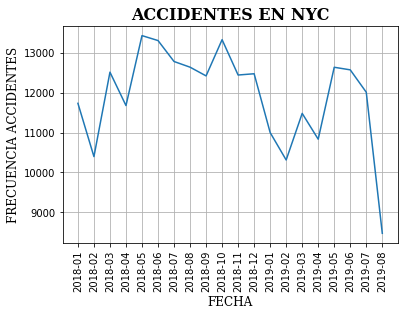

In [9]:
import matplotlib.pyplot as plt
dfc = df.copy()
dfc['DATE'] = pd.to_datetime(dfc['DATE'], format="%m/%d/%Y")
unos = [1]*len(df)
print(len(df))
dfc['COUNT'] = unos
dfMes =  dfc.groupby(dfc['DATE'].dt.strftime('%Y-%m'))['COUNT'].sum().sort_index()
#print(dfMes)
fig,ax = plt.subplots()
plt.plot(dfMes.index, dfMes.values)
plt.xticks(rotation=90)
plt.xlabel("FECHA", fontdict={'family': 'serif', 'size': 12})
plt.ylabel("FRECUENCIA ACCIDENTES", fontdict={'family': 'serif', 'size': 12})
plt.title("ACCIDENTES EN NYC", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
plt.grid(True)
plt.show()

**Respuesta:** Durante el ultimo año y medio se evidencia que el numero de accidentes ha fluctuado de acuerdo a los meses, teniendo que en Febrero se dan las frecuencias mas bajas y en Mayo, Junio y Octubre las tres más altas. Además en general el número de accidentes en 2019 disminuyó con respecto a 2018. 

### Ejercicio 3

De la gráfica anterior, ¿qué meses parecen tener el menor número de accidentes? ¿Cuáles crees que son las razones detrás de esto?

**Respuesta.** 


En los dos años se evidencia que el mes con menor numero de accidentes es Febrero. La razón de esto, es que en Febrero en Estados Unidos están en invierno, con temperaturas muy bajas y las personas generalmente no salen

### Ejercicio 4 
¿Cómo varía el número de accidentes a lo largo de un solo día? Cree una nueva columna `HOUR` basada en los datos de la columna `TIME`, luego trace un gráfico de barras de la distribución por hora a lo largo del día.

**Sugerencia:** Puede encontrar útil la función ```dt.hour```.

**Respuesta.**

In [10]:
dfc['TIME'] = df[['DATE', 'TIME']].apply(' '.join, axis=1)

In [11]:
dfc['TIME'] = pd.to_datetime(dfc['TIME'])

Text(0.5, 1.0, 'ACCIDENTES POR HORA EN NYC')

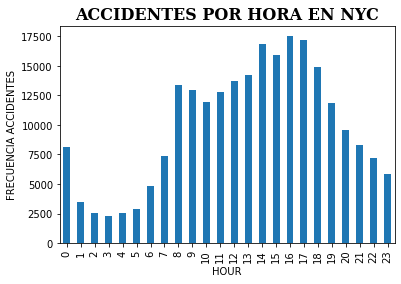

In [12]:
dfc['HOUR'] = dfc['TIME'].dt.hour
dfHoras = dfc.groupby(dfc['HOUR']).size()
dfHoras.plot.bar()
plt.ylabel('FRECUENCIA ACCIDENTES')
plt.title("ACCIDENTES POR HORA EN NYC", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})

A lo largo de un día el número de accidentes empieza a aumentar desde las 3 hasta llegar al pico más alto entre las 16 y las 18 horas, luego de esto empieza a disminuir hasta las 23 horas , aumenta un poco a las 0 horas y de alli dismunuye de nuevo, presentandose el menor numero de accidentes a las 3 horas. 

### Ejercicio 5 

En la pregunta anterior hemos agregado el número de accidentes por hora sin tener en cuenta la fecha y el lugar en que ocurrieron. ¿Qué crítica le daría a este enfoque?

**Respuesta.** 
De esta forma es posible saber el promedio de accidentes por hora en el dia en el periodo estudiado(01-2018 a 08-2019), sin embargo, 
- No es posible saber el comportamiento en un mes en especifico por horas
- No es posible saber si en un cierto lugar a cierta hora es mas propenso un accidente
- No es posible saber si el comportamiento por horas cambio de un año al otro

### Ejercicio 6 

¿Cómo varía el número de accidentes en una sola semana? Trace un gráfico de barras basado en el recuento de accidentes por día de la semana.

**Sugerencia:** Puede encontrar útil la función ```dt.weekday```.

**Respuesta.**

Text(0.5, 1.0, 'ACCIDENTES POR DIA EN NYC')

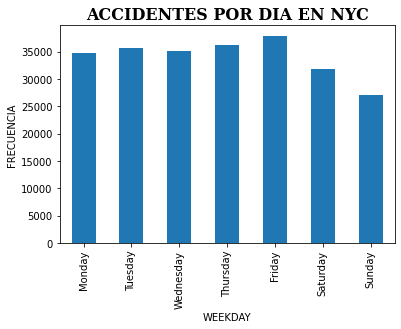

In [15]:
#dfc['WEEKDAY'] = dfc['TIME'].dt.weekday
dfc['WEEKDAY'] = dfc['TIME'].dt.day_name()
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dfWeekday = dfc.groupby(dfc['WEEKDAY']).size().reindex(days)
#print(dfWeekday)
dfWeekday.plot.bar()
plt.ylabel('FRECUENCIA')
plt.title("ACCIDENTES POR DIA EN NYC", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})

De la gráfica anterior se puede concluir que el dia de la semana con mayor numero de accidentes es el Viernes y el dia con menor frecuencia el Domingo. Sin embargo de Lunes a Viernes las frecuencias no varian mucho, notandose más la diferencia el fin de semana, donde la frecuencia baja

### Ejercicio 7

Trace una gráfica de barras del número total de accidentes en cada municipio, así como uno de los accidentes por milla cuadrada por municipio. ¿Qué puedes concluir?

**Sugerencia:** Es posible que desee actualizar algunas de las claves en el diccionario del municipio para que coincidan con los nombres en el marco de datos.

**Respuesta.**

BOROUGH
BRONX            37709
BROOKLYN         76253
MANHATTAN        48749
QUEENS           67120
STATEN ISLAND     8691
dtype: int64


Text(0.5, 1.0, 'ACCIDENTES POR MUNICIPIO EN NYC')

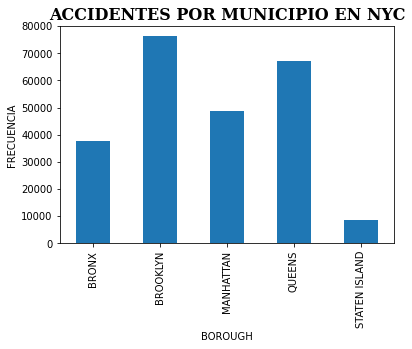

In [18]:
dfMunicipio = dfc.groupby(dfc['BOROUGH']).size()
dfMunicipio.plot.bar()
print(dfMunicipio)
plt.ylabel('FRECUENCIA')
plt.title("ACCIDENTES POR MUNICIPIO EN NYC", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})

**Conclusion:** De la anterior gráfica se concluye que el municipio con mayor cantidad de accidentes es Brooklyn y el de menor Staten Island

In [19]:
#REEMPLAZO DE CLAVES EN DICCIONARIO DE MUNICIPIOS
borough_data_reemplazo = {'brooklyn': 'BROOKLYN', 'manhattan': 'MANHATTAN', 'queens': 'QUEENS', 'staten island': 'STATEN ISLAND', 'the bronx': 'BRONX'}
borough_data_nuevo =  dict((borough_data_reemplazo[key], value) for (key, value) in borough_data.items())
borough_data_nuevo

{'BRONX': {'area': 42.1, 'name': 'the bronx', 'population': 1471160.0},
 'BROOKLYN': {'area': 70.82, 'name': 'brooklyn', 'population': 2648771.0},
 'MANHATTAN': {'area': 22.83, 'name': 'manhattan', 'population': 1664727.0},
 'QUEENS': {'area': 108.53, 'name': 'queens', 'population': 2358582.0},
 'STATEN ISLAND': {'area': 58.37,
  'name': 'staten island',
  'population': 479458.0}}

BOROUGH
BRONX             896
BROOKLYN         1077
MANHATTAN        2136
QUEENS            619
STATEN ISLAND     149
dtype: int64


Text(0.5, 1.0, 'ACCIDENTES POR MILLA CUADRADA POR MUNICIPIO EN NYC')

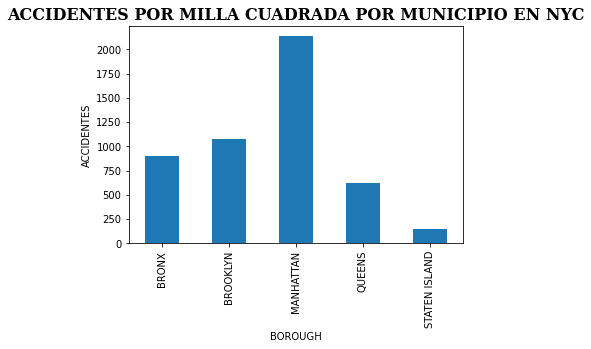

In [20]:
import math
dfConcentracion = (dfc.groupby(dfc['BOROUGH']).size())
for i in list(dfConcentracion.index): 
  area = borough_data_nuevo[i]['area']
  dfConcentracion[i] = math.ceil(dfConcentracion[i]/area)
dfConcentracion.plot.bar()
print(dfConcentracion)
plt.ylabel('ACCIDENTES')
plt.title("ACCIDENTES POR MILLA CUADRADA POR MUNICIPIO EN NYC", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})

**Conclusión: ** Sin embargo, al normalizar los datos, se puede ver en la grafica anterior que la frecuencia más alta es para Manhattan, pero la más baja si se mantiene para Staten Island

### Ejercicio 8 

¿Qué horas tienen más accidentes en cada municipio? Trace un gráfico de barras para cada municipio que muestre el número de accidentes por cada hora del día.

**Sugerencia:** Puede usar ```sns.FacetGrid``` para crear una cuadrícula de parcelas con los datos por hora de cada municipio.

**Respuesta.**

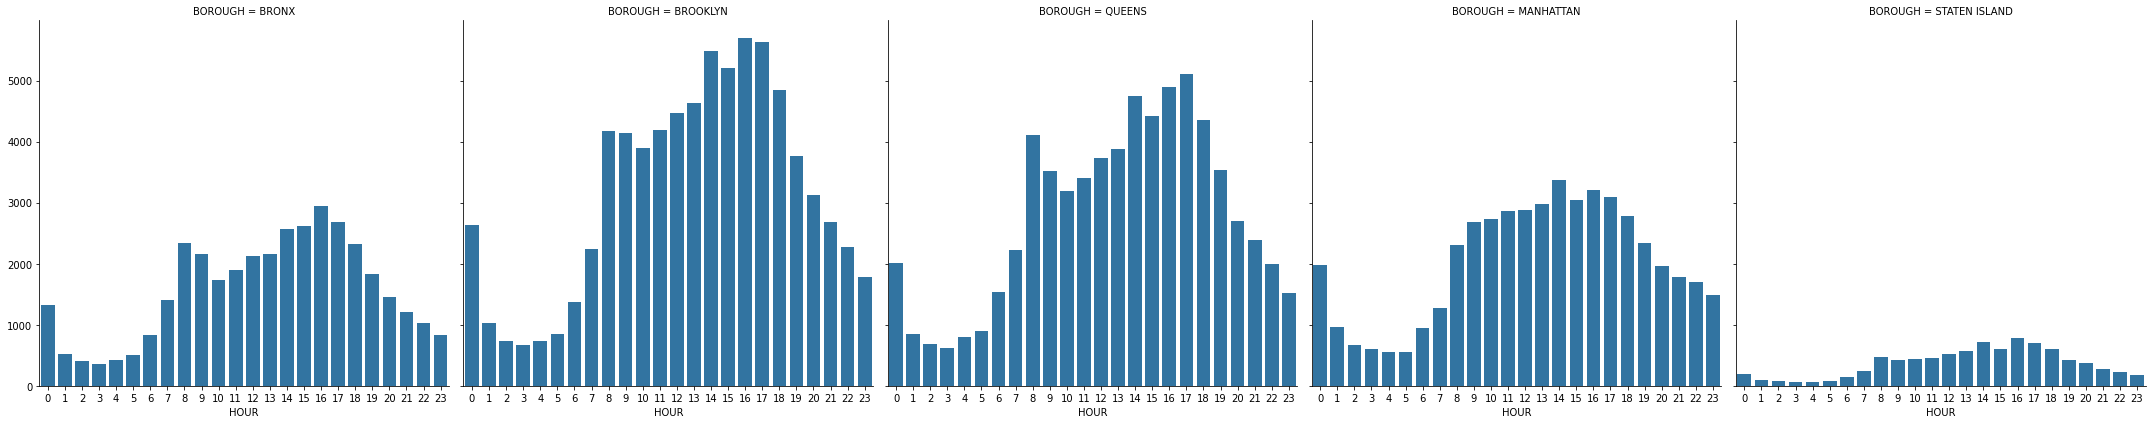

In [21]:
dfMunicipioHora = dfc.groupby(by = ['BOROUGH', 'HOUR']).size()
#dfMunicipioHour = dfMunicipioHora.to_frame()
listaMunicipios = list(dfMunicipioHora.index.get_level_values('BOROUGH').unique())
times = list(dfMunicipioHora.index.get_level_values('HOUR').unique())
g = sns.FacetGrid(dfc, col='BOROUGH', height=6)
g = g.map(sns.countplot, "HOUR", order=times)

Hora a la que se presenta mayor cantidad de accidentes: 
- Bronx: 16 horas
- Brooklyn: 16 horas
- Queens: 17 horas
- Manhattan: 14 horas
- Staten Island: 16 horas

**¿Es mayor el número de accidentes en diferentes momentos en diferentes distritos? ¿Deberíamos concentrarnos en diferentes momentos para cada municipio?**

**Respuesta:** En general la mayor cantidad de accidentes se dan entre las 16 y las 18 horas, y solo en Manhattan se da esta situacion entre las 13  y 14 horas. Sin embargo, estos dos intervalos: [16-18] y [13-14] representan los picos mas altos en todos los municipios.

### Ejercicio 9 

¿Qué factores provocan la mayoría de los accidentes? Evite contar dos veces los factores que contribuyen a un solo accidente.

**Sugerencia:** Una forma de lidiar con las repeticiones es concatenar las columnas correspondientes conservando sus índices, puede hacerlo con las funciones ```pd.concat()``` y ```reset_index()```. Luego, use un ```group_by``` apropiado para contar el número de repeticiones de factores contribuidos por accidente.

**Respuesta**.


In [23]:
columnas = [dfc['CONTRIBUTING FACTOR VEHICLE 1'], dfc['CONTRIBUTING FACTOR VEHICLE 2'], dfc['CONTRIBUTING FACTOR VEHICLE 3'], dfc['CONTRIBUTING FACTOR VEHICLE 4'], dfc['CONTRIBUTING FACTOR VEHICLE 5']]
dfFactores = pd.concat(columnas, join='inner').reset_index()
dfFactores.columns = ['INDEX', 'FACTOR']
dfFactores_accidents = dfFactores.groupby('FACTOR')['INDEX'].nunique()
print('-------Factores de accidentes en NYC----------')
dfFactores_accidents.sort_values(ascending=False)
#len(list(dfFactores_accidents.index))

-------Factores de accidentes en NYC----------


FACTOR
Unspecified                                              190096
Driver Inattention/Distraction                            61752
Failure to Yield Right-of-Way                             19641
Following Too Closely                                     17293
Backing Unsafely                                          14835
Passing Too Closely                                       12631
Passing or Lane Usage Improper                            11808
Other Vehicular                                            8860
Unsafe Lane Changing                                       6643
Turning Improperly                                         6626
Traffic Control Disregarded                                4687
Driver Inexperience                                        4152
Unsafe Speed                                               3469
Reaction to Uninvolved Vehicle                             3034
Alcohol Involvement                                        2491
View Obstructed/Limited          

**Conclusion:** Despues de evidenciar que en la mayoria de veces no se tiene la causa del accidente, se encuentra que el factor principal de accidentes es la distracción del conductor, no ceder el derecho de paso, seguir demasiado cerca, retroceder inseguramente, pasar demasiado cerca y adelantar o usar el carril incorrectamente.

### Ejercicio 10 

¿Qué tipos de vehículos están más involucrados en accidentes por municipio? Evite contar dos veces el tipo de vehículos presentes en un solo accidente.

**Sugerencia:** Puede aplicar un enfoque similar al utilizado en la pregunta anterior.

**Respuesta.** 

In [25]:
#RESULTADOS POR MUNICIPIO
tipo1 = dfc[['BOROUGH', 'VEHICLE TYPE CODE 1']] 
tipo2 = dfc[['BOROUGH', 'VEHICLE TYPE CODE 2']]
tipo3 = dfc[['BOROUGH', 'VEHICLE TYPE CODE 3']]
tipo4 = dfc[['BOROUGH', 'VEHICLE TYPE CODE 4']]
tipo5 = dfc[['BOROUGH', 'VEHICLE TYPE CODE 5']]
tipo1.columns = ['BOROUGH', 'VEHICLE']
tipo2.columns = ['BOROUGH', 'VEHICLE']
tipo3.columns = ['BOROUGH', 'VEHICLE']
tipo4.columns = ['BOROUGH', 'VEHICLE']
tipo5.columns = ['BOROUGH', 'VEHICLE']
dfVehiculosMunicipios = pd.concat([tipo1, tipo2, tipo3, tipo4, tipo5]).reset_index()
dfVehiculosMunicipios.columns = ['INDEX', 'BOROUGH', 'VEHICLE']
dfMunicipioVeh = dfVehiculosMunicipios.groupby(by= ['BOROUGH', 'VEHICLE'])['INDEX'].nunique()
boroughlist = list(borough_data_nuevo.keys())
print('----------Resultados por municipio---------------')
for i in boroughlist:
  print(i, dfMunicipioVeh[i].sort_values(ascending=False)[:6])
  print('-----------------------------------')

----------Resultados por municipio---------------
BRONX VEHICLE
Sedan                                  19652
Station Wagon/Sport Utility Vehicle    15434
PASSENGER VEHICLE                       4941
SPORT UTILITY / STATION WAGON           3751
Pick-up Truck                           1670
Taxi                                    1623
Name: INDEX, dtype: int64
-----------------------------------
BROOKLYN VEHICLE
Sedan                                  39459
Station Wagon/Sport Utility Vehicle    32262
PASSENGER VEHICLE                      10177
SPORT UTILITY / STATION WAGON           8099
Pick-up Truck                           3195
Box Truck                               2367
Name: INDEX, dtype: int64
-----------------------------------
MANHATTAN VEHICLE
Sedan                                  20727
Station Wagon/Sport Utility Vehicle    16432
Taxi                                    8989
PASSENGER VEHICLE                       5627
SPORT UTILITY / STATION WAGON           4415
Box Truck   

**Respuesta:** Se encuentra que en todos los municipios los tipos de vehiculos más involucrados en accidentes son: Sedan y Station Wagon/Sport Utility, además Passenger Vehicle está en tercer lugar en casi todos los municipios, excepto en Manhattan donde este lugar es ocupado por el Taxi

In [29]:
#RESULTADOS EN GENERAL
vehiculos = [dfc['VEHICLE TYPE CODE 1'], dfc['VEHICLE TYPE CODE 2'], dfc['VEHICLE TYPE CODE 3'], dfc['VEHICLE TYPE CODE 4'], dfc['VEHICLE TYPE CODE 5']]
dfVehiculos = pd.concat(vehiculos).reset_index()
dfVehiculos.columns = ['INDEX', 'VEHICLE']
dfVehiculos_accidents = dfVehiculos.groupby('VEHICLE')['INDEX'].nunique()
print('-------Resultados en general-------------')
dfVehiculos_accidents.sort_values(ascending=False)[:30]
#dfVehiculos_accidents.filter(like='UTILITY')

-------Resultados en general-------------


VEHICLE
Sedan                                  119714
Station Wagon/Sport Utility Vehicle     99146
PASSENGER VEHICLE                       31228
SPORT UTILITY / STATION WAGON           25059
Taxi                                    14584
Pick-up Truck                           10864
Box Truck                                8509
Bike                                     6264
Bus                                      5848
TAXI                                     4497
PICK-UP TRUCK                            2774
Van                                      2515
Tractor Truck Diesel                     2317
TK                                       2048
Motorcycle                               1888
BU                                       1720
Dump                                     1105
BICYCLE                                  1006
Convertible                               987
Ambulance                                 792
PK                                        712
Garbage or Refuse         

### Ejercicio 11 

En 2018 para una [entrevista](https://www.nytimes.com/2019/01/01/nyregion/traffic-deaths-decrease-nyc.html) con The New York Times, el alcalde de Blasio de Nueva York declaró que *'Vision Zero está funcionando claramente'*. Ese año, el número de muertes en accidentes de tráfico en Nueva York se redujo a un histórico 202. Sin embargo, según lo informado por [am New York Metro](https://www.amny.com/news/vision-zero-de-blasio- 1-30707464 /), el número de víctimas mortales ha aumentado un 30% en el primer trimestre de 2019 en comparación con el año anterior y el número de peatones y ciclistas heridos no ha experimentado ninguna mejora.

¿Cómo utilizaría los datos proporcionados para comprender qué salió mal en el primer trimestre de 2019?


> - [ ] Considere los accidentes del primer trimestre de 2019. Luego, busque las causas más comunes de accidentes en los que estuvieron involucrados peatones y ciclistas. Dé una recomendación basada únicamente en esta información.

> - [ ] Cree un par de mapas de calor de los accidentes que involucraron a peatones y ciclistas lesionados / muertos en el primer trimestre de 2018 y 2019. Compare estos dos para ver si hay algún cambio en la concentración de accidentes. En áreas críticas, estudie el tipo de factores involucrados en los accidentes. Dé una recomendación para visitar estas áreas para estudiar más el problema.   

> - [ ] Los datos proporcionados son insuficientes para mejorar nuestra comprensión de la situación.

> - [ ] Ninguna de las anteriores. Haría lo siguiente: *aquí tu respuesta recomendada*.

**Respuesta.**


### Ejercicio 12 

Calcula el número de muertes provocadas por cada tipo de vehículo. Trace un gráfico de barras para los 5 vehículos principales. ¿Qué vehículos están involucrados con mayor frecuencia en las muertes y cuánto más que los demás?

**Por ejemplo,** si dos personas murieron en un accidente en el que estuvieron involucrados 5 vehículos: 4 son VEHÍCULOS DE PASAJEROS y 1 es un VAGÓN DEPORTIVO / ESTACIÓN. Luego, agregaríamos dos muertes a cada tipo de VEHÍCULO DE PASAJEROS y VAGÓN DE ESTACIÓN / SERVICIO DEPORTIVO.

**Sugerencia:** Es posible que desee crear una nueva columna con el número total de muertes en el accidente. Para eso, puede encontrar útil la función ```.to_numpy()```. Luego, proceda como los ejercicios anteriores para evitar contabilizar dos veces el tipo de vehículos.

**Repsuesta.**